## Flow Classification Task 

For this task we perform classification first on packet level and the on host level for scenario 10 (https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/) in the CTU-13 dataset.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from imblearn.over_sampling import SMOTE
from helper_functions.classification import *

Keep the number of infected and normal ips given by the scenario.

In [2]:
infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206', '147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36, 147.32.80.9', '147.32.87.11']


Load the preprocessed data from the task 4.

In [3]:
data = pd.read_csv('./data/capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


NaNs do occur in features `Src_Port` and `Dst_Port`. These will be dealt with the discretization applied later on. The used function pd.factorize() map NaNs to -1. Hence, no action is required here.

In [4]:
nans = data.isna().values
np.sum(nans, axis=0)

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0, 374017,      0, 375948,      0])

Remove background flows.

In [5]:
# remove background 
data_nobground = data[ data['Label'] != 'Background']
print("Shape: ", data_nobground.shape)

data_nobground.head()

Shape:  (645358, 13)


,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
20,4.985,TCP,PA_,0,91,86277,1,LEGITIMATE,147.32.80.13,80,147.32.85.88,56949,2011-08-18 10:19:13.347
51,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.86.110,48102,74.125.232.214,443,2011-08-18 10:19:13.392
57,4.921,TCP,A_,0,49,3234,1,LEGITIMATE,147.32.85.88,56949,147.32.80.13,80,2011-08-18 10:19:13.411
73,4.742,TCP,A_,0,118,7080,1,LEGITIMATE,147.32.84.59,2768,74.125.108.208,80,2011-08-18 10:19:13.460
75,0.000,TCP,A_,0,1,60,1,LEGITIMATE,147.32.84.59,56058,74.125.232.215,443,2011-08-18 10:19:13.486


The next visualization investigates potential imbalance on packet level. Clearly, there is no such with the two classes `BOTNET` and `LEGITIMATE` being equally represented.

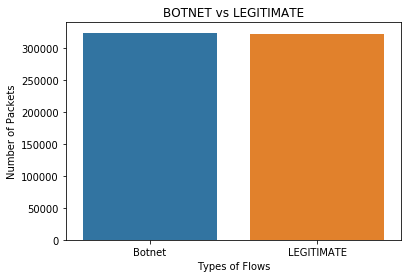

Number of Botnet:  323441
Number of Legitimate:  321917
Ratio:  1.0047341395452865


In [6]:
# Check for imbalance
ax = data_nobground['Label'].value_counts()
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x=ax.index, y= ax)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.show()

val_1 = len(data_nobground[data_nobground['Label'] == 'Botnet'])
val_2 = len(data_nobground[data_nobground['Label'] == 'LEGITIMATE'])
print("Number of Botnet: ", val_1)
print("Number of Legitimate: ", val_2)
print("Ratio: ", val_1/val_2)

Mapping the malicious, `BOTNET` class as the positive label.

In [7]:
# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}


label_mapping['Label'] = {'LEGITIMATE':0, 'Botnet':1}
data_nobground.replace({'Label' : label_mapping['Label']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = ['Prot', 'Flags']

for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize(data_nobground[c])

# Uncomment this line, if you want to see the mapppings for the conversion
label_mapping

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


{'Label': {'LEGITIMATE': 0, 'Botnet': 1},
 'Prot': Index(['TCP', 'UDP', 'ICMP'], dtype='object'),
 'Flags': Index(['PA_', 'A_', 'FA_', 'SPA_', 'FPA_', 'INT', 'FSA_', '_FSA', 'FSPA_',
        '_FSPA', 'S_', 'RA_', 'FSRPA_', 'SA_', '_FSRPA', 'SRPA_', 'FRPA_',
        'ECO', 'URH', 'SR_', 'FRA_', 'RPA_', 'R_', 'FSPAEC_', 'SRA_', '_FSRA',
        'URP', 'PAC_', 'MAS', 'TST', 'IRR', 'ECR', 'RTS', 'RTA', 'IRQ', 'UNK',
        'MSR', 'TSR', 'SEC', 'ROB', 'MRQ', 'RED', 'IAH', 'TXD', 'DNQ', 'PTB',
        'PAR', 'NRA', 'WAY', 'PHO', '___', 'AHA', 'NRS', 'MHR', 'UR', 'NNA',
        'MRP', 'TRC', 'DCE', 'SKP', 'SRC', 'NNS', 'DNP', 'URN', 'URPRE', 'URS',
        'URNU', 'URCUT', 'URISO', 'URNPRO', 'URHPRO', 'URHTOS', 'URHU', 'SPAC_',
        'SEC_', 'FSRA_', 'URFIL', 'FSPAC_'],
       dtype='object')}

In [8]:
# We keep a copy of the data set to used for the host level.
new_nobground = data_nobground.copy()

### Convesion of categorical data to numeric

Each column of type "object" is converted, based on an enumeration of its unique values. We did not use one-hot encoding for the conversion, as this would lead to unnecessary creation of extra columns, thus to the increase of the dimensionality of feature space.

In [9]:
char_cols =  data_nobground.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize( data_nobground[c])

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Drop the labels
labels = data_nobground['Label'].values
X = data_nobground.drop(['Label','Datetime'], axis = 1).values
print("Dataset shape: ", X.shape)

Dataset shape:  (645358, 11)


### Classification on packet level
For the classification on the packet level, each netflow is considered independently. The task is to classify a set of unseen-test netflows as bening (class 0) or malicious (class 1). We used the following classifiers:
- Naive Bayes
- Random Forrest 

In [11]:
# 10-Fold stratified cross validation with shuffling of the dataset before extracting the stratified splits,
# used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

As seen from the reported performance metrics, even a simple classifier as NaiveBayes is able to perform very well in this task. This is most probably attributed to the high number of available training samples, comparing to the dimensionality of the feature space.

The mean ROC curve is plotted obtained averaged from all the cross-validation splits. Additionally, the reported confusion matrix in form [[TP,FP],[FN,TN]] report the summed values obtained from the validation splits. The reported metrics (accuracy, precision, recall, F1_score) correspond to the final, aggregated confusion matrix.

For the documentation of the used helper functions (`roc_analysis` and `performance_metrics`) please refer to `helper_functions/classification.py`.

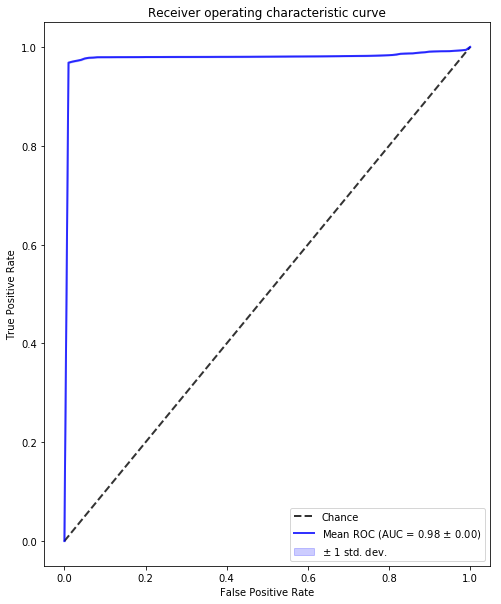

[[313581   4471]
 [  9860 317446]]
Accuracy: 0.978
Precision: 0.986
Recall: 0.970
F1_score: 0.978


In [12]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
_, _, _, _, _, _, cm =roc_analysis(X, labels, clf, cv, False, True, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

As expected, Random Forest yiels nearly impeccable performance, with only 3 FP and 12 FN!

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


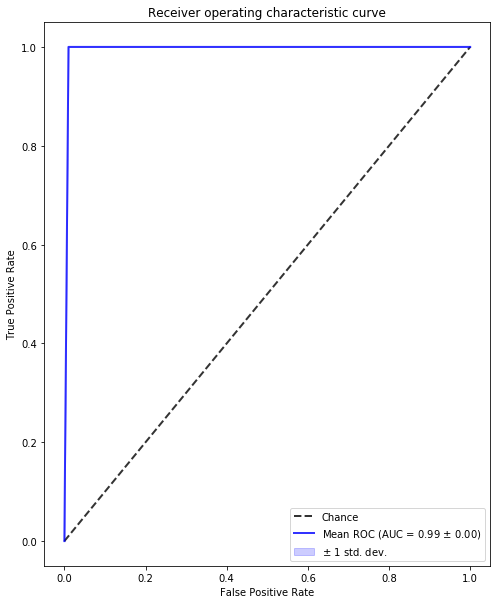

[[323429      3]
 [    12 321914]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1_score: 1.000


In [13]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm =roc_analysis(X, labels, clf, cv, False, True, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

### Classification on Host Level 
This time the classification task changes. We aggregate values by `Src_IP_Addr`, to get per_host values. The task is not to classify hosts as normal(class 0), or infected (class 1).

Regarding the labels, we consider as infected a host which has took part in a malicious flow as source.

In [14]:
data_perhost = new_nobground.groupby('Src_IP_Addr').agg({'Durat':'sum', 'Prot':'sum', 'Flags':'sum', 'Tos':'sum', 'Packets':'sum', 'Bytes':'sum', 'Flows':'sum', 'Label':'max'})
data_perhost['Dst_IPs'] = new_nobground.groupby('Src_IP_Addr')['Dst_IP_Addr'].nunique()
data_perhost['Src_Ports'] = new_nobground.groupby('Src_IP_Addr')['Src_Port'].nunique()
data_perhost['Dst_Ports'] = new_nobground.groupby('Src_IP_Addr')['Dst_Port'].nunique()

hosts = data_perhost.index

In [15]:
data_perhost.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Dst_IPs,Src_Ports,Dst_Ports
Src_IP_Addr,,,,,,,,,,,
10.10.20.233,50.096,0,249,0,132,8712,75,0,1,23,1
10.168.115.232,3.624,0,20,0,9,778,5,0,1,1,1
10.168.48.160,4.897,0,16,0,6,534,4,0,1,1,1
10.23.106.55,3.565,0,8,0,6,511,2,0,1,1,1
10.23.12.43,4.556,0,16,0,6,1583,4,0,2,2,2


In [16]:
labels = data_perhost['Label'].values
data_perhost.drop(labels='Label', axis=1, inplace=True)
X = data_perhost.values

print(X.shape)
print("Imbalance ratio: ", np.sum(labels)/np.sum(labels==0))

(522, 10)
Imbalance ratio:  0.14725274725274726


Here there is some, but not great imbalance (comparing to the imbalance encountered for the 1st Lab assignment). We will consider applying SMOTE, but we do not expect to see significant change in performance for the considered classifiers.

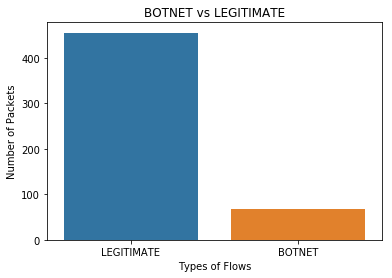

Number of infected: 67
Number of normal: 455


In [17]:
ax, counts = np.unique(labels, return_counts=True)
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x= ax, y=counts)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.xticks(range(2), ['LEGITIMATE', 'BOTNET'])
plt.show()

print('Number of infected:', counts[1])
print('Number of normal:', counts[0])

Here, we do perform 5-fold stratified cross-validation, since the dataset size is now much smaller and a 10-fold split would lead to really low number of training samples for the infected class.

In [18]:
num_splits = 5
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

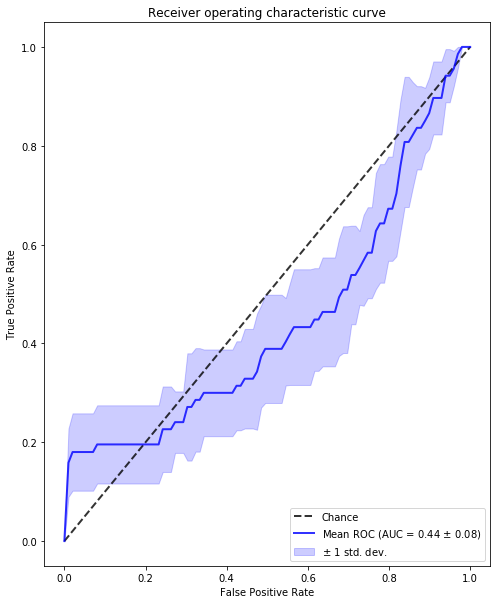

[[ 11   4]
 [ 56 451]]
Accuracy: 0.885
Precision: 0.733
Recall: 0.164
F1_score: 0.268


In [19]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
_, _, _, _, _, _, cm =roc_analysis(X, labels, clf, cv, False, True, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

Applying SMOTE for various number of over-sampling ratios and number of neighbours. We do tune these parameters again using cross-validation (again 5-fold stratified), based on max reported F1-score. Regarding the printed matrices, rows correspond to sampling ratios and columns to number of neighbours.

As expected, we see no significant change in the F1-score of NaiveBayes classifier (0.268 without SMOTE). The highest value is reported for ratio=0.2 and 3 negihbours.  We saw that repeating these measurements yielded slightly different values, but the final performance obtained by the 'SMOTEd' classifier was almost identical to the one reported below, hence we did not investigate further.

In [22]:
# Use cross-validation to determine the best overasmpling ratio
ratios = np.array([ 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([1,2,3,5,10])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)


i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, labels, clf, cv, 
                                                                                False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
# print("std AUC:\n", std_auc_cv)
print("Mean F1:\n", m_F1_cv)
# print("std F1:\n", std_F1_cv)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean AUC:
 [[0.47855052 0.48652829 0.49847678 0.48112292 0.49731952]
 [0.48328518 0.46548906 0.52555839 0.46887226 0.4750446 ]
 [0.47658066 0.45673462 0.47133573 0.48466988 0.48098456]
 [0.49188017 0.48684099 0.48053977 0.47331972 0.48439058]]
Mean F1:
 [[0.25813209 0.26055973 0.26558824 0.25228758 0.26021672]
 [0.26093567 0.24468672 0.26328173 0.25453044 0.25392157]
 [0.26264706 0.25515873 0.26150794 0.25372549 0.24611111]
 [0.25643521 0.25761856 0.25686275 0.24991597 0.25888889]]


Naive Bayes with SMOTE. Clearly no significant change in performance.

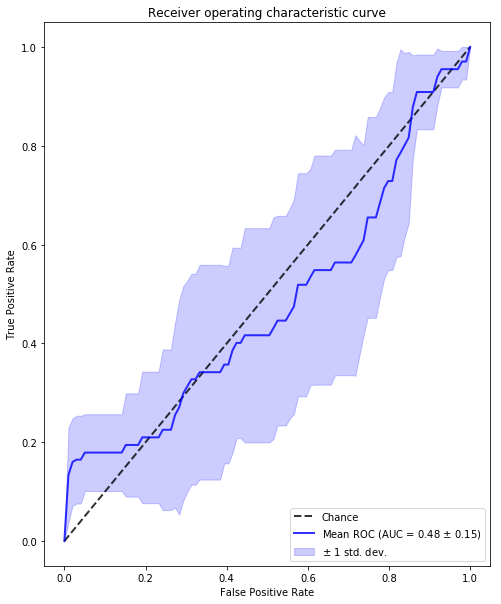

[[ 11   5]
 [ 56 450]]
Accuracy: 0.883
Precision: 0.688
Recall: 0.164
F1_score: 0.265


In [23]:
sm = SMOTE(sampling_strategy=0.2, k_neighbors=3)

clf = GaussianNB()
_, _, _, _, _, _, cm =roc_analysis(X, labels, clf, cv, False, True, False,sm)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)


The RandomForest classifier performs much better. This was expected as it is a more powerfull, ensemble method.

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


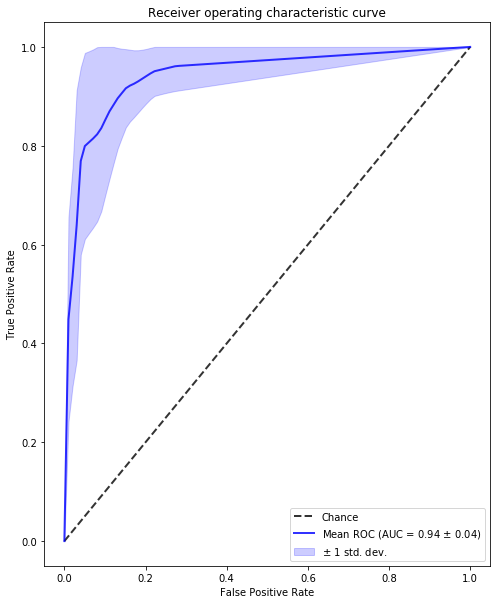

[[ 42   9]
 [ 25 446]]
Accuracy: 0.935
Precision: 0.824
Recall: 0.627
F1_score: 0.712


In [24]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
_, _, _, _, _, _, cm =roc_analysis(X, labels, clf, cv, False, True, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

Testing for SMOTE. Max F1-score reported for sampling ratio 0.5 and 2 neighbours. We saw that repeating these measurements yielded slightly different values, but the final performance obtained by the 'SMOTEd' classifier was almost identical to the one reported below, hence we did not investigate further.

In [25]:
# Use cross-validation to determine the best overasmpling ratio
ratios = np.array([ 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([1,2,3,5,10])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)


i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, labels, clf, cv, 
                                                                                False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
# print("std AUC:\n", std_auc_cv)
print("Mean F1:\n", m_F1_cv)
# print("std F1:\n", std_F1_cv)

Mean AUC:
 [[0.9494035  0.93734474 0.9486664  0.95825804 0.95206528]
 [0.95565922 0.96487191 0.94760532 0.95859459 0.9550973 ]
 [0.94506061 0.96072173 0.957755   0.95761327 0.95678519]
 [0.94825523 0.93200168 0.94533963 0.95763832 0.95986809]]
Mean F1:
 [[0.74909133 0.74514286 0.79161804 0.76723277 0.70061376]
 [0.7625641  0.8173545  0.73110863 0.81218143 0.78097179]
 [0.74736996 0.76673187 0.78008534 0.79691005 0.72669294]
 [0.75960758 0.74667172 0.779426   0.72272578 0.76021978]]


Performance of Random Forest with SMOTE.

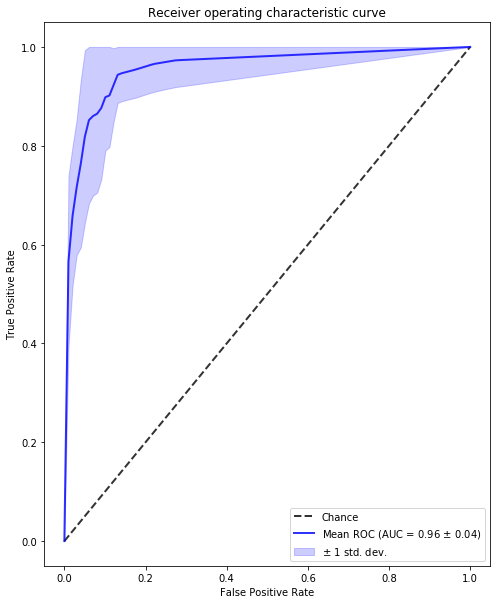

[[ 50  18]
 [ 17 437]]
Accuracy: 0.933
Precision: 0.735
Recall: 0.746
F1_score: 0.741


In [26]:
sm = SMOTE(sampling_strategy=0.5, k_neighbors=2)
_, _, _, _, _, _, cm =roc_analysis(X, labels, clf, cv, False, True, False,sm)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)